# Exploração de dados

## Bibliotecas

### Instalação

In [112]:
%pip install mlflow==2.21.0
%pip install kagglehub==0.3.13
%pip install pandas==2.3.3
%pip install numpy
%pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Importação

In [113]:
import mlflow
import kagglehub
import shutil
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from typing import Any
from dataclasses import dataclass


## Configurações

### Constantes

In [114]:
LOCAL_DATA_PATH=Path("./data")
ARTIFACTS_PATH=LOCAL_DATA_PATH / "artifacts"

DATASET_KAGGLE_NAME="kritanjalijain/amazon-reviews"
DATASET_TRAIN="train.csv"
DATASET_TEST="test.csv"
DATASET_SPLIT_COUNT=10
DATASET_TRAIN_RANGE=100_000
DATASET_LOCAL_PATH=LOCAL_DATA_PATH / "dataset"
DATASET_POLARITY_COLUMN="polarity"
DATASET_TITLE_COLUMN="title"
DATASET_MESSAGE_COLUMN="text"
DATASET_COLUMNS=[DATASET_POLARITY_COLUMN, DATASET_TITLE_COLUMN, DATASET_MESSAGE_COLUMN]
DATASET_FULL_TEXT_COLUMN="full_text"

MLFLOW_HOST="http://localhost"
MLFLOW_PORT=5500
MLFLOW_EXPERIMENT_NAME="eda_experiment"


### MLFlow

In [115]:
mlflow.set_tracking_uri(f"{MLFLOW_HOST}:{MLFLOW_PORT}")
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1763700927702, experiment_id='1', last_update_time=1763700927702, lifecycle_stage='active', name='eda_experiment', tags={}>

## Dataset

### Baixa o dataset

In [116]:
with mlflow.start_run(run_name="dataset_download"):
    dataset_path = Path(kagglehub.dataset_download(DATASET_KAGGLE_NAME))
    local_raw_path = DATASET_LOCAL_PATH / "raw"
    local_raw_path.mkdir(parents=True, exist_ok=True)

    shutil.copy(dataset_path / DATASET_TRAIN, local_raw_path / DATASET_TRAIN)
    shutil.copy(dataset_path / DATASET_TEST, local_raw_path / DATASET_TEST)

    mlflow.log_param("dataset_name", DATASET_KAGGLE_NAME)
    mlflow.log_param("dataset_local_path", local_raw_path.as_uri)


🏃 View run dataset_download at: http://localhost:5500/#/experiments/1/runs/d28d78b8042946ec915316b9f6b369b0
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Carrega em memória

In [117]:
df_train_raw = pd.read_csv(local_raw_path / DATASET_TRAIN, engine="python", header=None)
df_train_raw.columns = DATASET_COLUMNS
df_test_raw = pd.read_csv(local_raw_path / DATASET_TEST, engine="python", header=None)
df_test_raw.columns = DATASET_COLUMNS

### Divide o dataset

In [118]:
with mlflow.start_run(run_name="dataset_split"):
    shuffle_args = {
        "frac": 1,
        "random_state": 42
    }

    df_train_raw_shuffled = df_train_raw.sample(**shuffle_args).reset_index(drop=True)
    df_train_raw_subset = df_train_raw_shuffled.iloc[:DATASET_TRAIN_RANGE]

    for k, v in shuffle_args.items():
        mlflow.log_param(f"dataset_shuffle_args_{k}", v)

    mlflow.log_param("dataset_split_count", DATASET_SPLIT_COUNT)
    mlflow.log_param("dataset_selected_batch", 0)
    mlflow.log_param("dataset_train_subset", DATASET_TRAIN_RANGE)

🏃 View run dataset_split at: http://localhost:5500/#/experiments/1/runs/aff99e74b2b8428f88e60260821beb2f
🧪 View experiment at: http://localhost:5500/#/experiments/1


## EDA

### Infos do dataset

,polarity,title,text
0,1,Expensive Junk,This product consists of a piece of thin flexi...
1,1,Toast too dark,"Even on the lowest setting, the toast is too d..."
2,2,Excellent imagery...dumbed down story,I enjoyed this disc. The video is stunning. I ...
3,1,Are we pretending everyone is married?,The authors pretend that parents neither die n...
4,1,Not worth your time,"Might as well just use a knife, this product h..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  100000 non-null  int64 
 1   title     99993 non-null   object
 2   text      100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


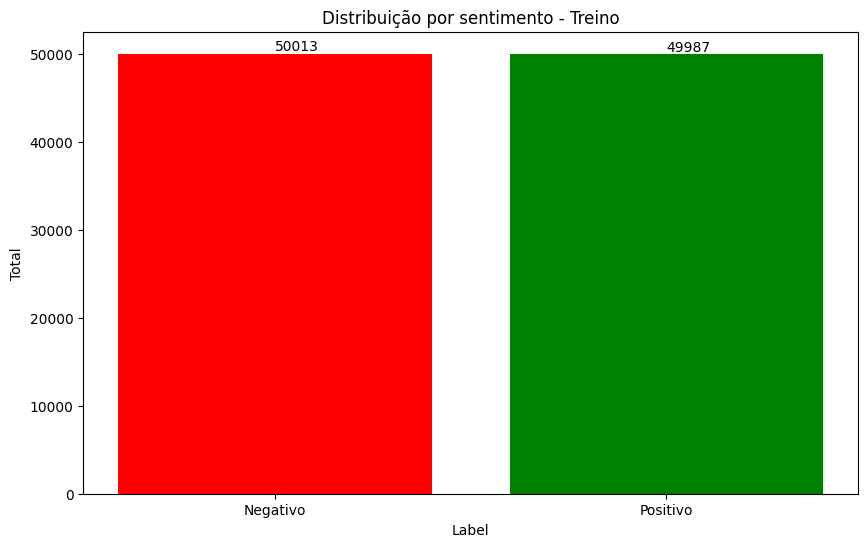

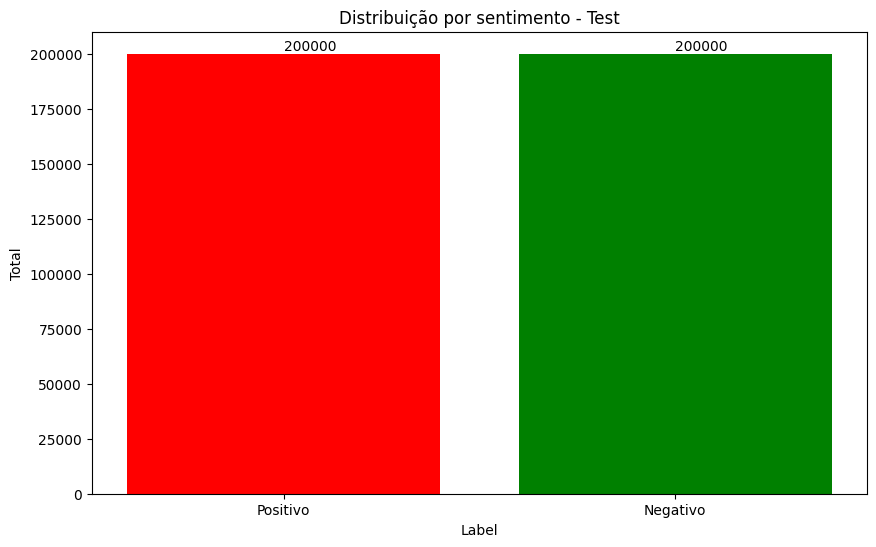

In [119]:
display(df_train_raw_subset.head())
df_train_raw_subset.info()

def show_dataset_into(df: pd.DataFrame, title: str):
    polarity_names = {1: 'Negativo', 2: 'Positivo'}
    polarity_counts = df[DATASET_COLUMNS[0]].value_counts()

    labels = list(map(polarity_names.get, polarity_counts.index))

    colors = ['red', 'green']

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, polarity_counts, color=colors)

    # Adicionar os totais em cima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Total')
    plt.show()

show_dataset_into(df=df_train_raw_subset, title="Distribuição por sentimento - Treino")
show_dataset_into(df=df_test_raw, title="Distribuição por sentimento - Test")

## Preparação dos dados

### Utilitários para o Dataset

In [120]:
def title_and_text_null_treatment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles null values in title and text columns.

    - Removes rows where BOTH title and text are null.
    - Fills remaining null values (title OR text individually null) with empty strings.
    - Logs metrics to MLflow for auditing and reproducibility.

    Returns:
        pd.DataFrame: cleaned dataframe with valid title/text content.
    """

    if DATASET_TITLE_COLUMN not in df.columns:
        raise KeyError(f"Column '{DATASET_TITLE_COLUMN}' not found in DataFrame")

    if DATASET_MESSAGE_COLUMN not in df.columns:
        raise KeyError(f"Column '{DATASET_MESSAGE_COLUMN}' not found in DataFrame")

    ## Remove rows when both is null
    mask_both_null = df[DATASET_TITLE_COLUMN].isna() & df[DATASET_MESSAGE_COLUMN].isna()
    rows_to_remove_count = int(mask_both_null.sum())

    df = df.loc[~mask_both_null].copy()

    ## Fill empty remaing rows
    title_null_count = df[DATASET_TITLE_COLUMN].isna().sum()
    text_null_count  = df[DATASET_MESSAGE_COLUMN].isna().sum()
    df[DATASET_TITLE_COLUMN] = df[DATASET_TITLE_COLUMN].fillna("")
    df[DATASET_MESSAGE_COLUMN]  = df[DATASET_MESSAGE_COLUMN].fillna("")

    mlflow.log_metric("rows_dropped_title_text_null", rows_to_remove_count)
    mlflow.log_metric("rows_title_null_filled", title_null_count)
    mlflow.log_metric("rows_text_null_filled", text_null_count)
    return df

def preprocess_record(title: str, message: str) -> str:
    """
    Combines title and message into a single string and applies basic normalization:
    - lowercasing
    - removal of URLs
    - normalization of whitespace

    Returns:
        str: new text concactaned title and message, and removed withspaces and URLs
    """

    combined = f"{title} {message}".strip().lower()

    # Remove URLs
    combined = re.sub(r"http\S+", "", combined)

    # Normalize whitespace
    combined = re.sub(r"\s+", " ", combined)

    return combined

def build_full_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new 'full_text' column containing the normalized combination
    of title + text. Removes the original title/text columns afterwards.

    Returns:
        pd.DataFrame: dataframe containing only full_text instead of title/text.
    """
    df[DATASET_FULL_TEXT_COLUMN] = df.apply(
        lambda row: preprocess_record(title=row[DATASET_TITLE_COLUMN], message=row[DATASET_MESSAGE_COLUMN]),
        axis=1,
    )

    rows_before = len(df)
    df = df[df[DATASET_FULL_TEXT_COLUMN].str.len() > 0].copy()
    rows_after = len(df)

    df = df.drop(columns=[DATASET_TITLE_COLUMN, DATASET_MESSAGE_COLUMN])

    mlflow.log_metric("rows_dropped_empty_full_text", rows_before - rows_after)

    return df

### Normaliza o dataset de treino

In [121]:
with mlflow.start_run(run_name="preprocessing"):
    rows_before = len(df_train_raw_subset)

    df_train_clear = title_and_text_null_treatment(df_train_raw_subset)
    df_train_clear = build_full_text(df_train_clear)

    rows_after = len(df_train_clear)

    mlflow.log_metric("rows_before_preprocessing", rows_before)
    mlflow.log_metric("rows_after_preprocessing", rows_after)


🏃 View run preprocessing at: http://localhost:5500/#/experiments/1/runs/5412264519e142988dfb28d9e0603ce0
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Split do treino de validação

In [122]:

with mlflow.start_run(run_name="split_train_val"):
    test_size = 0.2
    random_state = 42

    train_df, val_df = train_test_split(
        df_train_clear,
        test_size=test_size,
        stratify=df_train_clear[DATASET_POLARITY_COLUMN],
        random_state=random_state
    )

    mlflow.log_param("split_test_size", test_size)
    mlflow.log_param("split_random_state", random_state)
    mlflow.log_metric("split_train_len", len(train_df))
    mlflow.log_metric("split_val_len", len(val_df))


🏃 View run split_train_val at: http://localhost:5500/#/experiments/1/runs/35e309424ed24a3b928a2d7b9de301d2
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Gera os eixos de treino

In [123]:
X_train = train_df[DATASET_FULL_TEXT_COLUMN].values
y_train = train_df[DATASET_POLARITY_COLUMN].values

X_val = val_df[DATASET_FULL_TEXT_COLUMN].values
y_val = val_df[DATASET_POLARITY_COLUMN].values

## Treinamento do modelo

### 🧩 Tokenização (definição dos args do tokenizer)

In [124]:
tfidf_grid_args = {
    "tfidf__max_features": [20_000, 50_000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [2, 5],
}


### Treinamento

In [125]:
@dataclass
class TrainGridResult:
    best_estimator: Pipeline
    acc: float
    f1: float

def validate(estimator_pipeline: Pipeline, X_data, y_data, split_name: str = "val") -> dict[str, float]:
    # Validation
    y_pred = estimator_pipeline.predict(X_data)
    acc = accuracy_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred, average="macro")

    mlflow.log_metric(f"{split_name}_accuracy", acc)
    mlflow.log_metric(f"{split_name}_f1_macro", f1)

    print(f"[{split_name}] Accuracy:", acc)
    print(f"[{split_name}] F1 macro:", f1)
    print(classification_report(y_data, y_pred))

    return {"accuracy": acc, "f1_macro": f1}


def train_grid(etimator_pipeline: Pipeline, clf_grid_params: dict[str, Any], pipeline_name: str) -> TrainGridResult:
    grid_params = {
        **tfidf_grid_args,
        **clf_grid_params
    }

    grid = GridSearchCV(
        estimator=etimator_pipeline,
        param_grid=grid_params,
        cv=3,
        n_jobs=-1,
        scoring="f1_macro",
        verbose=1,
    )

    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))

    grid.fit(X_train, y_train)

    # melhor conjunto
    best_params = grid.best_params_
    best_score = grid.best_score_

    mlflow.log_params(best_params)

    mlflow.log_metric("cv_f1_macro_best", best_score)

    cv_results_df = pd.DataFrame(grid.cv_results_)
    ARTIFACTS_PATH.mkdir(exist_ok=True)
    cv_results_path = ARTIFACTS_PATH / f"{pipeline_name}_grid_cv_results.csv"
    cv_results_df.to_csv(cv_results_path, index=False)

    mlflow.log_artifact(str(cv_results_path), artifact_path="cv_results")

    mlflow.sklearn.log_model(
        sk_model=grid.best_estimator_,
        artifact_path="model"
    )

    mlflow.set_tag("model_name", f"tfidf_{pipeline_name}_v1")
    mlflow.set_tag("search_type", "grid")
    mlflow.set_tag("search_version", "v1")

    # Validation
    metrics = validate(estimator_pipeline=grid.best_estimator_, X_data=X_val, y_data=y_val)

    return TrainGridResult(
        best_estimator=grid.best_estimator_,
        acc=metrics["accuracy"],
        f1=metrics["f1_macro"]
    )

### Modelo v1

In [126]:
with mlflow.start_run(run_name="model_v1_tfidf_logreg"):
    logreg_grid_params = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["liblinear", "lbfgs"],
    }

    pipeline_logreg = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", LogisticRegression(max_iter=1000)),
    ])

    logreg_grid_result = train_grid(etimator_pipeline=pipeline_logreg, clf_grid_params=logreg_grid_params, pipeline_name="logreg")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025/11/21 12:47:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[val] Accuracy: 0.9141
[val] F1 macro: 0.9140996211793293
              precision    recall  f1-score   support

           1       0.91      0.92      0.91     10003
           2       0.92      0.91      0.91      9997

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

🏃 View run model_v1_tfidf_logreg at: http://localhost:5500/#/experiments/1/runs/b80df983cdd543c3b90ab0dbdc37c5fb
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Modelo v2

In [127]:
with mlflow.start_run(run_name="model_v1_tfidf_svm"):
    svm_grid_params = {
        "clf__C": [0.1, 1, 10]
    }

    pipeline_svm = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", LinearSVC()),
    ])

    svm_grid_result = train_grid(etimator_pipeline=pipeline_svm, clf_grid_params=svm_grid_params, pipeline_name="svm")


Fitting 3 folds for each of 24 candidates, totalling 72 fits


2025/11/21 12:50:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[val] Accuracy: 0.91125
[val] F1 macro: 0.9112486152565196
              precision    recall  f1-score   support

           1       0.91      0.91      0.91     10003
           2       0.91      0.91      0.91      9997

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

🏃 View run model_v1_tfidf_svm at: http://localhost:5500/#/experiments/1/runs/9e20a2058197470d8a6727b68bd7a75f
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Comparando os modelos

In [128]:
if svm_grid_result.f1 > logreg_grid_result.f1:
    best_name = "svm"
    best_result = svm_grid_result
else:
    best_name = "logreg"
    best_result = logreg_grid_result

print(f"Melhor modelo: {best_name}")
print(f"F1: {best_result.f1:.4f}")
print(f"Accuracy: {best_result.acc:.4f}")

final_model = best_result.best_estimator


Melhor modelo: logreg
F1: 0.9141
Accuracy: 0.9141


## Testando o modelo selecionado

### Preprocessando o dataset de teste

In [129]:
with mlflow.start_run(run_name="preprocessing_test"):
    rows_before = len(df_test_raw)

    df_test_clear = title_and_text_null_treatment(df_test_raw)
    df_test_clear = build_full_text(df_test_clear)

    rows_after = len(df_test_clear)

    mlflow.log_metric("rows_before_preprocessing", rows_before)
    mlflow.log_metric("rows_after_preprocessing", rows_after)


🏃 View run preprocessing_test at: http://localhost:5500/#/experiments/1/runs/9c011bdf34ba45bfba4fb095823bd963
🧪 View experiment at: http://localhost:5500/#/experiments/1


### Validando

In [130]:
X_test = df_test_clear[DATASET_FULL_TEXT_COLUMN].values
y_test = df_test_clear[DATASET_POLARITY_COLUMN].values

with mlflow.start_run(run_name="test_dataset"):
    test_result = validate(estimator_pipeline=final_model, X_data=X_test, y_data=y_test, split_name="test")


[test] Accuracy: 0.916835
[test] F1 macro: 0.9168349420152424
              precision    recall  f1-score   support

           1       0.92      0.92      0.92    200000
           2       0.92      0.92      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000

🏃 View run test_dataset at: http://localhost:5500/#/experiments/1/runs/5cee8b979b5841af90229eb986d0a8e7
🧪 View experiment at: http://localhost:5500/#/experiments/1


## Salvando o melhor modelo

In [131]:
with mlflow.start_run(run_name="final_model_v1"):
    mlflow.set_tag("best_model", best_name)
    mlflow.log_metric("test_accuracy", test_result["accuracy"])
    mlflow.log_metric("test_f1_macro", test_result["f1_macro"])

    mlflow.log_param("test_size", len(X_test))

    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model"
    )

    print("Modelo final salvo no MLflow como final_model_v1")


2025/11/21 12:52:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo final salvo no MLflow como final_model_v1
🏃 View run final_model_v1 at: http://localhost:5500/#/experiments/1/runs/a3a3f86f0e744709bd303905b0ec8a46
🧪 View experiment at: http://localhost:5500/#/experiments/1
